In [8]:
import antares

In [9]:
# Imports
import antares.devkit as dk
dk.init()
# You should see a happy message that says that "ANTARES DevKit is ready!"

Jaeger tracer already initialized, skipping


Prometheus failed to start with [Errno 98] Address already in use
Testing loading a random Locus with `dk.get_locus()`...

ANTARES v2.11.0 DevKit is ready!
Website: https://antares.noirlab.edu
Documentation: https://nsf-noirlab.gitlab.io/csdc/antares/antares/



In [3]:
# Define a Paczyński microlensing model
def paczynski(t, t0, u0, tE, F_s):
    """
    Paczyński microlensing light curve model
    t0 : peak time
    u0 : impact parameter
    tE : Einstein crossing time
    F_s : source flux
    F_b : blended flux
    """
    u = np.sqrt(u0**2 + ((t - t0) / tE) ** 2)
    A = (u**2 + 2) / (u * np.sqrt(u**2 + 4))
    return F_s * (A - 1) + (1-F_s)

def mag_to_flux(mag, F0=1.0):
    """
    Convert magnitude to flux.
    
    Parameters:
    - mag : magnitude (float or array)
    - F0 : reference flux (zeropoint), default=1.0 for relative flux
    
    Returns:
    - flux : flux corresponding to the magnitude
    """
    flux = F0 * 10**(-0.4 * mag)
    flux = flux/np.min(flux)
    return flux
    
def magerr_to_fluxerr(mag, mag_err, F0=1.0):
    """
    Convert magnitude uncertainty to flux uncertainty.
    
    Parameters:
    - mag : magnitude value or array
    - mag_err : magnitude uncertainty value or array
    - F0 : zeropoint flux (default=1.0 for relative flux)
    
    Returns:
    - flux_err : flux uncertainty
    """
    flux = mag_to_flux(mag, F0)
    flux_err = 0.4 * np.log(10) * flux * mag_err
    return flux_err

# Writing a preliminary microlensing filter that reads in the photometry

In [48]:
from statsmodels.stats.weightstats import DescrStatsW
import numpy as np
from astropy.table import MaskedColumn
import warnings
import astropy
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import skew

#from antares_microlensing_filter import microlensing

class microlensing(dk.Filter):    
    INPUT_LOCUS_PROPERTIES = [
        'ztf_object_id',
    ]
    
    REQUIRED_TAGS = [ 'lc_feature_extractor' ]
    
    OUTPUT_TAGS = [
        {
            'name': 'microlensing_candidate',
            'description': 'Locus - a transient candidate - exhibits a microlensing-like variability',
        }
    ]


    def make_lc(self, locus):

        with warnings.catch_warnings():
            # The cast of locus.timeseries: astropy.table.Table to a pandas
            # dataframe results in the conversion of some integer-valued
            # columns to floating point represntation. This can result in a
            # number of noisy warning so we will catch & ignore them for the
            # next couple of lines.
            warnings.simplefilter("ignore", astropy.table.TableReplaceWarning)
            df = locus.timeseries.to_pandas()

        data = df[['ant_mjd', 'ztf_fid', 'ztf_magpsf', 'ztf_sigmapsf']]
        
        dn = data.dropna()
        times=dn['ant_mjd'][dn['ztf_fid']==1]
        mags = dn['ztf_magpsf'][dn['ztf_fid']==1]
        mags_err = dn['ztf_sigmapsf'][dn['ztf_fid']==1]
        flxs = mag_to_flux(mags)
        flx_errs = magerr_to_fluxerr(mags, mags_err)
        
        t0_guess = times[np.argmin(mags)]  # Min mag is peak time
        u0_guess = 1/(np.max(flxs))

        initial_fit  = paczynski(times,
                                     t0_guess, 
                                     u0_guess, 
                                     20, 
                                     0.5)

        # plt.gca().invert_yaxis()
        plt.scatter(times, 
                    flxs, color='g', label='g_band')
        plt.plot(times, 
                 initial_fit, color='b', label='initial fit')
        
        plt.xlabel('Time (mjd)')
        plt.ylabel('Flux')
        plt.legend()


    def is_microlensing_candidate(self, locus, times, mags, errors):
        
        #Example of a set of Microlensing detection criteria
        
        if len(times) < 10:  # Too few data points
            return False

        # Check preexisting parameters for signs of variability
        locus_params = locus.to_dict()
        period_peak_sn_threshold = 20.0
        stetson_k_threshold = 2.0
        if locus_params['properties']['feature_period_s_to_n_0_magn_r'] >= period_peak_sn_threshold:
            return False
        if locus_params['properties']['feature_stetson_k_magn_r'] >= stetson_k_threshold:
            return False
            
        # Sort data by time
        sorted_idx = np.argsort(times)
        times, mags, errors = times[sorted_idx], mags[sorted_idx], errors[sorted_idx]

        # 1. Check for smoothness (low skewness means symmetric light curve)
        # TODO: Check for threshold with parallax and maybe remove or lower threshold
        if abs(skew(mags)) > 1:
            return False

        # TODO is 6 months and a year - calculate this based on percentile of real data
        eta_thresh = 1.255
        # Do check for existance since if there's only one band of data, only one will exist
        eta_r_exists = 'feature_eta_e_magn_r' in locus_params['properties'].keys()
        eta_g_exists = 'feature_eta_e_magn_g' in locus_params['properties'].keys()
        if eta_r_exists and eta_g_exists:
            if locus_params['properties']['feature_eta_e_magn_r'] >= eta_thresh and locus_params['properties']['feature_eta_e_magn_g'] >= eta_thresh:
                return False
        elif eta_r_exists:
            if locus_params['properties']['feature_eta_e_magn_r'] >= eta_thresh:
                return False
        elif eta_g_exists:
            if locus_params['properties']['feature_eta_e_magn_g'] >= eta_thresh:
                return False

        # 2. Check variability (microlensing should have a clear peak)
        # Decrease threshold with longer baseline
        # Q for broker - 365 days or full lightcurve?
        if np.ptp(mags) < 0.5:  # Peak-to-peak magnitude difference
            return False

        print('MADE IT TO FITTING')
        
        flxs = mag_to_flux(mags)
        flx_errs = magerr_to_fluxerr(mags, errors)

        # 3. Perform a lightweight template fit (Paczyński model)
        # TODO - Somayeh switch to KMTNet algorithm
        t0_guess = times[np.argmin(mags)]  # Min mag is peak time
        u0_guess = 1/(np.max(flxs))
        initial_guess = [t0_guess, 
                         u0_guess, 
                         20, 
                         0.5]  # Initial params

        # try:
        popt, _ = curve_fit(paczynski, times, flxs, p0=initial_guess, sigma=flx_errs)
        chi2 = np.sum(((flxs - paczynski(times, *popt)) / flx_errs) ** 2) / len(times)

        # 4. Apply a simple chi2 threshold
        if chi2 < 2:  # Well-fit light curves pass
            return True
        # except RuntimeError:
        #     return False  # Fit failed

        # TODO - Natasha add von Neumann residual (subtract out microlensing and see if you're still correlated)

        # TODO - Rache potentially query full lightcurve if not already there and if possible

        # TODO - Natasha add parallax microlensing fit

        return False
        
    def run(self, locus):
        print('Processing Locus:', locus.locus_id)

        with warnings.catch_warnings():
            warnings.simplefilter("ignore", astropy.table.TableReplaceWarning)
            df = locus.timeseries.to_pandas()

        data = df[['ant_mjd', 'ztf_fid', 'ztf_magpsf', 'ztf_sigmapsf']].dropna()

        
        
        # Split into g-band and i-band
        for band in [1, 2]:  # 1 = g-band, 2 = i-band
            band_data = data[data['ztf_fid'] == band]
            times, mags, errors = band_data['ant_mjd'].values, band_data['ztf_magpsf'].values, band_data['ztf_sigmapsf'].values
            
            if self.is_microlensing_candidate(locus, times, mags, errors):
                print(f'Locus {locus.locus_id} is a microlensing candidate in band {band}')
                locus.tag('microlensing_candidate')
        
        
        return

In [5]:
def plot_lightcurve(locus):
    df = locus.timeseries.to_pandas()
    
    data = df[['ant_mjd', 'ztf_fid', 'ztf_magpsf', 'ztf_sigmapsf']]
    
    dn = data.dropna()
    times=dn['ant_mjd'][dn['ztf_fid']==1]
    mags = dn['ztf_magpsf'][dn['ztf_fid']==1]
    mags_err = dn['ztf_sigmapsf'][dn['ztf_fid']==1]

    plt.errorbar(times, mags, yerr=mags_err, marker = '.', linestyle = 'None')
    plt.gca().invert_yaxis()
    plt.show()

    return


In [49]:
# Execute the microlensing filter on the locus
report = dk.run_filter(microlensing, locus="ANT2023wuk92lk9fz76")


Processing Locus: ANT2023wuk92lk9fz76
MADE IT TO FITTING
Locus ANT2023wuk92lk9fz76 is a microlensing candidate in band 1
MADE IT TO FITTING
Locus ANT2023wuk92lk9fz76 is a microlensing candidate in band 2


/data0/sw/antares-kernel/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [40]:
'feature_eta_e_magn_r' in report['locus_data'].to_dict()['properties'].keys()

True

In [44]:
print(report['new_tags'])

{'microlensing_candidate'}


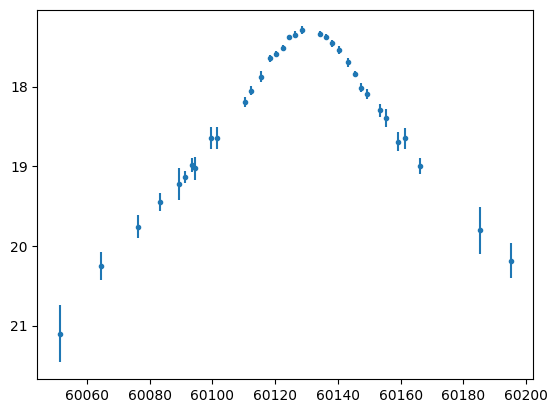

In [18]:
plot_lightcurve(report['locus_data'])

In [50]:
report = dk.run_many(microlensing, n=500)

# `run_many()` returns a report of what the filter did. Take a look at it:
print(report)

Processing Locus: ANT2025q0sul32zpdnl


/data0/sw/antares-kernel/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Processing Locus: ANT2018hbnj6
Processing Locus: ANT2020la2zm
Processing Locus: ANT202505k80bpr5xiu
Processing Locus: ANT2020sgkss


/data0/sw/antares-kernel/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Processing Locus: ANT2019dnp36
Processing Locus: ANT2025gz4gf7pt4iji
Processing Locus: ANT2025lmcjc1lh2j8i
Processing Locus: ANT2020katdq


/data0/sw/antares-kernel/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Processing Locus: ANT2019glnui
Processing Locus: ANT202074rsm
Processing Locus: ANT2020xroz6
Processing Locus: ANT2025ufhpkbpqav27
Processing Locus: ANT2018jboce
Processing Locus: ANT2020yxgrg
Processing Locus: ANT20204si2c
Processing Locus: ANT202076uz2
Processing Locus: ANT2019c7jzq
Processing Locus: ANT202261g65jlu0a28
Processing Locus: ANT2018klmvg
Processing Locus: ANT202076uz2
Processing Locus: ANT20245ndawmsp0yoy


/data0/sw/antares-kernel/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Processing Locus: ANT2020kdv4u
Processing Locus: ANT2020yxgrg
Processing Locus: ANT2019c5xmu
Processing Locus: ANT2025kiexjwrvz42a
Processing Locus: ANT2019c7jzq
Processing Locus: ANT20252mswn0o47580
Processing Locus: ANT2025ld79t9gm6br8


/data0/sw/antares-kernel/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Processing Locus: ANT2020trhv2
Processing Locus: ANT20248xxthw1pdjrg
Processing Locus: ANT2020kaxry


/data0/sw/antares-kernel/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Processing Locus: ANT2020l7rcw
Processing Locus: ANT20194qa4o
Processing Locus: ANT2020ypn24
Processing Locus: ANT2021uhmq2
Processing Locus: ANT2019ddnim
Processing Locus: ANT2020xrt6q


/data0/sw/antares-kernel/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Processing Locus: ANT2020rd63u
Processing Locus: ANT2024m8fghf3siwpx
Processing Locus: ANT2025qu9cusguh42w
Processing Locus: ANT2025df4695qwbylj
Processing Locus: ANT20251pnget4lgbac
Processing Locus: ANT20258bfqeypq9rha
Processing Locus: ANT2018e6npc
Processing Locus: ANT2024l90wlcvqqozn
Processing Locus: ANT2018oufyy
Processing Locus: ANT2021sdsks
Processing Locus: ANT2025t10x530unwnf


/data0/sw/antares-kernel/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Processing Locus: ANT2018fsoak
Processing Locus: ANT2019odofg
Processing Locus: ANT2024jeanxkpfaem8
Processing Locus: ANT2025qvpeb25tgay5


/data0/sw/antares-kernel/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Processing Locus: ANT2018hdary
Processing Locus: ANT2024tjmm7u0iw76e


/data0/sw/antares-kernel/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Processing Locus: ANT2018ftums
Processing Locus: ANT2019zpk7o
Processing Locus: ANT2025r3kv6nkduwjx
Processing Locus: ANT2024v5vxi7nybrml
Processing Locus: ANT20204ty2e
Processing Locus: ANT2018ftvyy
Processing Locus: ANT2019c3hze
Processing Locus: ANT2021uhmwg
Processing Locus: ANT2018iamka
Processing Locus: ANT2024b9pa9oai8h19
Processing Locus: ANT20194zyqu
Processing Locus: ANT2025ngljr7by2d9j
Processing Locus: ANT2025zh0h74osrww7
Processing Locus: ANT2019liigs
Processing Locus: ANT2020rikpi
Processing Locus: ANT2025ngljr7by2d9j
Processing Locus: ANT2024ghahw15bvkf5
Processing Locus: ANT2021ttda4
Processing Locus: ANT20259vok6ezf9jkr
Processing Locus: ANT2025kh2wj8oefm88
Processing Locus: ANT2025h9fmcg53p79a


/data0/sw/antares-kernel/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Processing Locus: ANT2020j7p2y


/data0/sw/antares-kernel/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Processing Locus: ANT20203nubu
Processing Locus: ANT2019c6pjg


/data0/sw/antares-kernel/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Processing Locus: ANT2020p4ovs
Processing Locus: ANT2021itezq
Processing Locus: ANT2020j736s
Processing Locus: ANT2019d6mga
Processing Locus: ANT2018fb6ic
Processing Locus: ANT202076p3y
Processing Locus: ANT202076quy
Processing Locus: ANT2025mlrssu5t0gfu
Processing Locus: ANT2019dmqzg
Processing Locus: ANT2019dkbnk
Processing Locus: ANT2025dfx11rs3xfc9
Processing Locus: ANT2025y17p7iip8w5v
Processing Locus: ANT2018ikyug
Processing Locus: ANT2018ja6lg
Processing Locus: ANT2019b3uie
Processing Locus: ANT2019xpcq6
Processing Locus: ANT2018e5vam
Processing Locus: ANT2018e533y
Processing Locus: ANT2020afi5tty
Processing Locus: ANT2020zubz2
Processing Locus: ANT2019czogs


/data0/sw/antares-kernel/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Processing Locus: ANT2019zpeum
Processing Locus: ANT2019ynxqm
Processing Locus: ANT2023pt3k6cxg8gnk
Processing Locus: ANT2020xsbqg


/data0/sw/antares-kernel/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Processing Locus: ANT2021cpvp4
Processing Locus: ANT20253bg21objug9e
Processing Locus: ANT2024n1lrlyzwob6c
Processing Locus: ANT2025rrncid7qe7it
Processing Locus: ANT2019c2pee
Processing Locus: ANT2025rj61ch3tbggn
Processing Locus: ANT2025rj61ch3tbggn
Processing Locus: ANT2020sgswi
Processing Locus: ANT2019c2o5g
Processing Locus: ANT20255i9sd7jcwz4n
Processing Locus: ANT2024hlbg96n4ye1d
Processing Locus: ANT20252riq8m1ef1ik
Processing Locus: ANT2025r8lbiof1gc09
Processing Locus: ANT20259o124c3ybxif
Processing Locus: ANT2020s5g6e
Processing Locus: ANT2020yxhaq
Processing Locus: ANT2025k2a9e2k8lxnh
Processing Locus: ANT2020xsi34
Processing Locus: ANT2020kb2xc
Processing Locus: ANT2018htpqg
Filter crashed:

'feature_period_s_to_n_0_magn_r'
Processing Locus: ANT2021uhnru
Processing Locus: ANT2025r9rnz1x5oj9x
Processing Locus: ANT202576wg8s3d66g9
Processing Locus: ANT2019ofbra
Processing Locus: ANT2019dpktg
Processing Locus: ANT2019ofeyw
Processing Locus: ANT2019dmx4k
Processing Locus: ANT2

/data0/sw/antares-kernel/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Processing Locus: ANT2020lzpcy
Processing Locus: ANT20257ygbt0x8c5xz
Processing Locus: ANT2018omslw


/data0/sw/antares-kernel/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Processing Locus: ANT2020lzpcy
Processing Locus: ANT2019g4rck
Processing Locus: ANT2020tsyfq
Processing Locus: ANT2020s5fgy
Processing Locus: ANT202536v6x7ul0mjh
Processing Locus: ANT202504em18wk1w3x
Processing Locus: ANT2025z35ojrt2gv4k
Processing Locus: ANT20258ksv2xf5ydaq
Processing Locus: ANT2025flch3pc18zxs
Processing Locus: ANT2025442eqrhuwytt
Processing Locus: ANT2019bj23u
Processing Locus: ANT2019lgpi2
Processing Locus: ANT2025rnexwdlqus2t
Processing Locus: ANT2025x1ln30ldi25t
Processing Locus: ANT2025swri32sapzqe
Processing Locus: ANT2025ryvnwosl4l8v
Processing Locus: ANT2019c3h6y


/data0/sw/antares-kernel/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Processing Locus: ANT2020rckiy
Processing Locus: ANT2025pldf36pdkssv
Processing Locus: ANT20254psq3pkz8xs0
Processing Locus: ANT2025swri32sapzqe
Processing Locus: ANT2025442eqrhuwytt
Processing Locus: ANT20251ja2bh3yg2hp
Processing Locus: ANT2019epaue
Processing Locus: ANT202076mx4
Processing Locus: ANT2020xsvgy
Processing Locus: ANT202558akm1328zhv
Processing Locus: ANT2020tbfqe
Processing Locus: ANT2025rpwu9cyc774x
Processing Locus: ANT2020xrpqq
Locus ANT2019of3yu skipped because it doesn't satisfy the filter constraints: a property is not in the Locus's input_properties or an input_tag is not in the Locus's input_tags.
Processing Locus: ANT2020afehu2y
Processing Locus: ANT2019y46tq
Processing Locus: ANT20204vvv2
Processing Locus: ANT2024qsfwnp52kabo
Processing Locus: ANT2020mcwr2
Processing Locus: ANT202594q1loncwkew
Processing Locus: ANT20206lrfs
Locus ANT2019offf4 skipped because it doesn't satisfy the filter constraints: a property is not in the Locus's input_properties or an inp

/data0/sw/antares-kernel/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Processing Locus: ANT2020ss6tg
Processing Locus: ANT2020ra4ae
Processing Locus: ANT2025svtocvzo51u0
Processing Locus: ANT2019icjy6
Processing Locus: ANT2023ace1fish1gsc
Processing Locus: ANT2019of6tc
Processing Locus: ANT2020aekxn4a
Processing Locus: ANT2020k2luk
Processing Locus: ANT2020afeht5a
Processing Locus: ANT2023mz9y6ske7swx
Processing Locus: ANT2021a5pjg
Processing Locus: ANT2020shs2w
Processing Locus: ANT2025pnkzdjm33rhd
Processing Locus: ANT2025d37jlaotkd1q
Processing Locus: ANT2025lzxpdz1b6gzl
Processing Locus: ANT2020pdmls


/data0/sw/antares-kernel/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Processing Locus: ANT2018fuaqw
Processing Locus: ANT20204styk
Processing Locus: ANT2025zrlny80d5f73
Processing Locus: ANT2019ogpl4
Processing Locus: ANT2019ofg6w
Processing Locus: ANT2020xsfi2
Processing Locus: ANT2019of2o4
Processing Locus: ANT2019hq37y


/data0/sw/antares-kernel/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Processing Locus: ANT2018hr7c2
Processing Locus: ANT2019y2pwu
Processing Locus: ANT2023wr6nwe6vr2qa
Processing Locus: ANT202511rqxrn12h2v
Processing Locus: ANT2018frq76
Processing Locus: ANT2025njg8rccv7ct2
Processing Locus: ANT2025g5f4u1c6uvpk
Processing Locus: ANT2025gs40fbti9l66
Processing Locus: ANT2020xsiyw
Processing Locus: ANT2019bw4d4
Processing Locus: ANT2025gs40fbti9l66
Processing Locus: ANT2020uwco4
Processing Locus: ANT2020xsiyw
Processing Locus: ANT20204owts
Processing Locus: ANT2025tyhjijaoh4j9
Processing Locus: ANT2020u7bf6
Processing Locus: ANT2020kzzyq
Processing Locus: ANT2019ofcfs
Processing Locus: ANT2025t1cyjv32r44u
Locus ANT2025kjtlp8ln1r2j skipped because it doesn't satisfy the filter constraints: a property is not in the Locus's input_properties or an input_tag is not in the Locus's input_tags.
Processing Locus: ANT2025tyhjijaoh4j9
Processing Locus: ANT20204owts
Processing Locus: ANT2025tgb598cfsgua
Processing Locus: ANT2020xrel2
Processing Locus: ANT2019ofvai
P

/data0/sw/antares-kernel/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Processing Locus: ANT2020mbt4w
Processing Locus: ANT2024h27np022yzzv
Processing Locus: ANT2024yw7ryitqysnp
Processing Locus: ANT20246yqhfptvvvlg
Processing Locus: ANT2025l4emq1ad5p84
Processing Locus: ANT2019eiknw
Processing Locus: ANT2025cmz6c98n9g24


/data0/sw/antares-kernel/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Processing Locus: ANT2020k3oxk


/data0/sw/antares-kernel/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Processing Locus: ANT2020j7pz6
Processing Locus: ANT2024jsdsi4kwgf81
Processing Locus: ANT2018ibgvq
Processing Locus: ANT2025lojuyqb0jg2p
Processing Locus: ANT2023ye1lefpstbg9
Processing Locus: ANT2025egexglsme7aw
Processing Locus: ANT20249vj4y06tezbd
Processing Locus: ANT2020kabak
Processing Locus: ANT2025h7gx6t2kw92f
Processing Locus: ANT20193n5gy
Processing Locus: ANT2021rll4q
Processing Locus: ANT20202bplk


/data0/sw/antares-kernel/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Processing Locus: ANT2019bblba
Processing Locus: ANT20241gh2hh8re6sw


/data0/sw/antares-kernel/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Processing Locus: ANT2019fdp42
Processing Locus: ANT2021hfgfg


/data0/sw/antares-kernel/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Processing Locus: ANT2018gjogu


/data0/sw/antares-kernel/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Processing Locus: ANT2019bblba
Processing Locus: ANT2020mgggk


/data0/sw/antares-kernel/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Processing Locus: ANT2020kzqsi
Processing Locus: ANT2025em5fiarro64i
Processing Locus: ANT2020ynjqy
Processing Locus: ANT2024lwwmhvagoy1x
Processing Locus: ANT2019of7ks


/data0/sw/antares-kernel/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Processing Locus: ANT2020usnyy


/data0/sw/antares-kernel/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Processing Locus: ANT2020k2wzc
Processing Locus: ANT2020rdx5a
Processing Locus: ANT2019ds7x2
Processing Locus: ANT20204kbyu
Processing Locus: ANT2018k5azq
Processing Locus: ANT2025stdisu3lsg3z
Processing Locus: ANT2025qm3afpi9yvf3


/data0/sw/antares-kernel/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Processing Locus: ANT2018frurm
Processing Locus: ANT2024npu0d1791yls
Processing Locus: ANT2024kc8p3a9ajqtj
Processing Locus: ANT2024kc8p3a9ajqtj
Processing Locus: ANT2019bcng2


/data0/sw/antares-kernel/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Processing Locus: ANT2018frurm
Processing Locus: ANT2024npu0d1791yls
Processing Locus: ANT2025y1b2dsse3jup


/data0/sw/antares-kernel/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Processing Locus: ANT2019jl4tg
Processing Locus: ANT2025hgemry4jlvtz
Processing Locus: ANT2021itlw6
Processing Locus: ANT2025el7f03eoh765
Processing Locus: ANT202074cdi
Processing Locus: ANT2025el7f03eoh765
Processing Locus: ANT2025asjgtgoi1lwq


/data0/sw/antares-kernel/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Processing Locus: ANT2018gyjsk


/data0/sw/antares-kernel/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Processing Locus: ANT20202jok4


/data0/sw/antares-kernel/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Processing Locus: ANT2020tm2ag
Processing Locus: ANT2018ibuxo
Processing Locus: ANT2019zd43e


/data0/sw/antares-kernel/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Processing Locus: ANT2018e7abe
Processing Locus: ANT20193gpcm


/data0/sw/antares-kernel/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Processing Locus: ANT2018hb4ai
Processing Locus: ANT2019zd43e


/data0/sw/antares-kernel/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Processing Locus: ANT2020njyeo


/data0/sw/antares-kernel/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Processing Locus: ANT2018e5y4a
Processing Locus: ANT20240mpo545nk4j7
Processing Locus: ANT20195anro
Processing Locus: ANT20252xk9rzzososm
Processing Locus: ANT2018e6hzu


/data0/sw/antares-kernel/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Processing Locus: ANT2018hbqqi


/data0/sw/antares-kernel/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Processing Locus: ANT2020md5wo
Processing Locus: ANT2019aqi7o
Processing Locus: ANT2019zgpka
Processing Locus: ANT2018laxj2
Processing Locus: ANT2018hnpwu


/data0/sw/antares-kernel/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Processing Locus: ANT2020s6fk4
Processing Locus: ANT2024et6pikkdnmao
Processing Locus: ANT20253kpwi0uyzh2b


/data0/sw/antares-kernel/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Processing Locus: ANT2018fsdb4
Processing Locus: ANT2019zjvrw


/data0/sw/antares-kernel/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Processing Locus: ANT2020mbzke


/data0/sw/antares-kernel/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Processing Locus: ANT2020lfitq
Processing Locus: ANT20253kpwi0uyzh2b


/data0/sw/antares-kernel/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Processing Locus: ANT2018hcss4
Processing Locus: ANT2020maoum
Filter crashed:

'feature_period_s_to_n_0_magn_r'
Processing Locus: ANT2019z4wb4
Processing Locus: ANT2019lkrgq
Processing Locus: ANT202589vzbk0s7iko
Processing Locus: ANT2018fta32
Processing Locus: ANT2020ywv6g
Processing Locus: ANT20256a4jboj86cgs
Processing Locus: ANT20202jcd4


/data0/sw/antares-kernel/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Processing Locus: ANT2018ibs66


/data0/sw/antares-kernel/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Processing Locus: ANT2020l34wo
Processing Locus: ANT20203d5ie


/data0/sw/antares-kernel/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Processing Locus: ANT2018frxmk


/data0/sw/antares-kernel/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Processing Locus: ANT2018ghjtg
Processing Locus: ANT2024mceu0rai8k1v


/data0/sw/antares-kernel/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Processing Locus: ANT2020pgfs6
Processing Locus: ANT2019ongxq


/data0/sw/antares-kernel/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Processing Locus: ANT201922lxo
Processing Locus: ANT2020afoqfry
Processing Locus: ANT20255cbevq6hdx3y
Processing Locus: ANT2019bnxtg
Processing Locus: ANT2025erdwvp4l59vm


/data0/sw/antares-kernel/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Processing Locus: ANT2020peghs
Processing Locus: ANT2020766k4
Processing Locus: ANT2019zfwfw


/data0/sw/antares-kernel/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Processing Locus: ANT2020tnoxw


/data0/sw/antares-kernel/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Processing Locus: ANT2018gye5i
Processing Locus: ANT20240k6eypbkm52w
Processing Locus: ANT2018fr56a
Processing Locus: ANT2024v3aq3bdp4vud
Processing Locus: ANT2018fszyw
Processing Locus: ANT2019ehjmc
Processing Locus: ANT2018laaj4
Processing Locus: ANT2025ft5sztvevvv3
Processing Locus: ANT2020kaywu
Processing Locus: ANT2018fbs7s


/data0/sw/antares-kernel/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Processing Locus: ANT2018ftfkq
Processing Locus: ANT20241yger52jy7rs
Processing Locus: ANT2024tyl0i9g76r6m
Processing Locus: ANT2018fsdsq


/data0/sw/antares-kernel/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Processing Locus: ANT2020p5pye
Processing Locus: ANT2024g0gmedvzi4kp
Processing Locus: ANT2025ft5sztvevvv3


/data0/sw/antares-kernel/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Processing Locus: ANT2018ftfkq
Processing Locus: ANT20241yger52jy7rs
Processing Locus: ANT2024tyl0i9g76r6m
Processing Locus: ANT2025z1mqc82xyn91
Processing Locus: ANT2018fvxwm
Processing Locus: ANT2025c1k4s5q9veh7
Processing Locus: ANT2025c1k4s5q9veh7
Processing Locus: ANT2019oe2q4
Processing Locus: ANT2022ayxp4oq5q3fg
Processing Locus: ANT2024jfl4jja8xmet
Processing Locus: ANT2024bg412tuvl0yr
Processing Locus: ANT2019zk4w4
Processing Locus: ANT2019dsqcm
Processing Locus: ANT2019bq5sw
Processing Locus: ANT2025yy4f0bvqmjof


/data0/sw/antares-kernel/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Processing Locus: ANT2018e5rtm


/data0/sw/antares-kernel/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Processing Locus: ANT2020kdffm
Processing Locus: ANT2020l7t3k


/data0/sw/antares-kernel/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Processing Locus: ANT2019g34uw


/data0/sw/antares-kernel/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Processing Locus: ANT2020kbto2


/data0/sw/antares-kernel/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Processing Locus: ANT2020katyc
Processing Locus: ANT2020ma7lq
Processing Locus: ANT2018fj7uq
Processing Locus: ANT2020rghmg
Processing Locus: ANT2020yxhyy
Processing Locus: ANT2025lhltm99f95bk


/data0/sw/antares-kernel/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Processing Locus: ANT2018e5rtm
Processing Locus: ANT2018fj7uq


/data0/sw/antares-kernel/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Processing Locus: ANT2020kdffm
Processing Locus: ANT2020l7t3k
Processing Locus: ANT2020rghmg
Processing Locus: ANT2020yxhyy


/data0/sw/antares-kernel/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Processing Locus: ANT2019zqa6s


/data0/sw/antares-kernel/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Processing Locus: ANT2020ouncg
Processing Locus: ANT2018g6pmy
Processing Locus: ANT2019zn3go
Processing Locus: ANT2018g6pmy


/data0/sw/antares-kernel/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Processing Locus: ANT2020ouncg


/data0/sw/antares-kernel/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Processing Locus: ANT202478p7jnm3zsxx
Processing Locus: ANT2025uc6579szvyv8


/data0/sw/antares-kernel/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Processing Locus: ANT2020lduno
Processing Locus: ANT2019zggpa
Processing Locus: ANT2018fjp5w
Processing Locus: ANT2024k643kseerc64


/data0/sw/antares-kernel/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Processing Locus: ANT2019fdnhm
Processing Locus: ANT2024i002ke92wigl
Processing Locus: ANT2019ek77e


/data0/sw/antares-kernel/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Processing Locus: ANT2019fdnhm
Processing Locus: ANT2024i002ke92wigl
Processing Locus: ANT2025diyyhcqw4hft
Processing Locus: ANT2021bga66
Processing Locus: ANT2025y4axvxub683w
Processing Locus: ANT2024hh6x8d69moj8
Processing Locus: ANT2018e65ha
Processing Locus: ANT2024xt6gfg9ucn4q
Processing Locus: ANT202559oe0ihqhg4q
Processing Locus: ANT2018e65ha
Processing Locus: ANT2025y4axvxub683w
Processing Locus: ANT2024hh6x8d69moj8


/data0/sw/antares-kernel/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Processing Locus: ANT2018fidmg


/data0/sw/antares-kernel/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Processing Locus: ANT2018hdwgo
Processing Locus: ANT2019kx2pa


/data0/sw/antares-kernel/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Processing Locus: ANT2020peoii
Processing Locus: ANT2025p6u09zqq4kla


/data0/sw/antares-kernel/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Processing Locus: ANT2018fiai4
Processing Locus: ANT2019yzyuc
Processing Locus: ANT2025i027epccs2q5
Processing Locus: ANT2019zgets
Processing Locus: ANT2019zgrqm
Processing Locus: ANT2020uj7pw
Processing Locus: ANT2019zggai


/data0/sw/antares-kernel/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Processing Locus: ANT2018hxpns
Processing Locus: ANT2019gbbho


/data0/sw/antares-kernel/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Processing Locus: ANT2020kbo6y
Processing Locus: ANT2018fsqdu
Processing Locus: ANT2025qje8opplsfio
Processing Locus: ANT2025ddc87h33u69f
Processing Locus: ANT20259zm40gdcc6m8
Processing Locus: ANT2025118yuws3gfk1
Processing Locus: ANT2020osuyy
Processing Locus: ANT2024fyqzlimpdjjm


/data0/sw/antares-kernel/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Processing Locus: ANT2018hdflw


/data0/sw/antares-kernel/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Processing Locus: ANT2018ialva
Processing Locus: ANT2025newxxp559kcl
Processing Locus: ANT2020qstoi
Processing Locus: ANT2020scddi
Processing Locus: ANT2020onoci


/data0/sw/antares-kernel/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Processing Locus: ANT2019zqvpg


/data0/sw/antares-kernel/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Processing Locus: ANT2018ggyiw
Processing Locus: ANT2018hc546
Processing Locus: ANT2024yagil25noujo


/data0/sw/antares-kernel/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Processing Locus: ANT2018hfo66


/data0/sw/antares-kernel/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Processing Locus: ANT2018htjfg
Processing Locus: ANT20259oc3r82r58sb
Processing Locus: ANT2018fjubc


/data0/sw/antares-kernel/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Processing Locus: ANT2020kbve6
Processing Locus: ANT202505jyf5zjny6n
Processing Locus: ANT2022be2yc
Processing Locus: ANT20203s6oa
Processing Locus: ANT202076l76


/data0/sw/antares-kernel/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Processing Locus: ANT2018e5sr4


/data0/sw/antares-kernel/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Processing Locus: ANT2020tnga4


/data0/sw/antares-kernel/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Processing Locus: ANT2020ka74w
Processing Locus: ANT2018fsc74


/data0/sw/antares-kernel/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Processing Locus: ANT2018ht3v6
Processing Locus: ANT202350hslxlo3hn3


/data0/sw/antares-kernel/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Processing Locus: ANT2018ht3v6
Processing Locus: ANT2019l5hry


/data0/sw/antares-kernel/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Processing Locus: ANT2020tq3qw
Processing Locus: ANT2019zn4m2
Processing Locus: ANT202350hslxlo3hn3
Processing Locus: ANT2024gwizby07nqt6
Processing Locus: ANT2020kawii
Processing Locus: ANT2020ndgc4
Processing Locus: ANT2020rg2k6


/data0/sw/antares-kernel/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Processing Locus: ANT2019z4hpu


/data0/sw/antares-kernel/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Processing Locus: ANT2018fsdk2
Processing Locus: ANT2024gwizby07nqt6
Processing Locus: ANT20193fo4s
Processing Locus: ANT2024jzrp8c44yodn


/data0/sw/antares-kernel/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Processing Locus: ANT2018fto62


/data0/sw/antares-kernel/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Processing Locus: ANT2018ftloc


/data0/sw/antares-kernel/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Processing Locus: ANT2020kamzi


/data0/sw/antares-kernel/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Processing Locus: ANT2018gyhrg
Processing Locus: ANT2019fdsng
Processing Locus: ANT2024nxq70kmoepph
{'n': 500, 'results': [{'locus_id': 'ANT2025q0sul32zpdnl', 'locus_data': FilterContext(locus_id="ANT2025q0sul32zpdnl"), 't': 0.012667854000028456, 'new_locus_properties': {}, 'new_alert_properties': {}, 'new_tags': set(), 'raised_halt': False}, {'locus_id': 'ANT2018hbnj6', 'locus_data': FilterContext(locus_id="ANT2018hbnj6"), 't': 0.0664526539999315, 'new_locus_properties': {}, 'new_alert_properties': {}, 'new_tags': set(), 'raised_halt': False}, {'locus_id': 'ANT2020la2zm', 'locus_data': FilterContext(locus_id="ANT2020la2zm"), 't': 0.05221556799995142, 'new_locus_properties': {}, 'new_alert_properties': {}, 'new_tags': set(), 'raised_halt': False}, {'locus_id': 'ANT202505k80bpr5xiu', 'locus_data': FilterContext(locus_id="ANT202505k80bpr5xiu"), 't': 0.011406834000013077, 'new_locus_properties': {}, 'new_alert_properties': {}, 'new_tags': set(), 'raised_halt': False}, {'locus_id': 'ANT202

939.6567350015013
set()


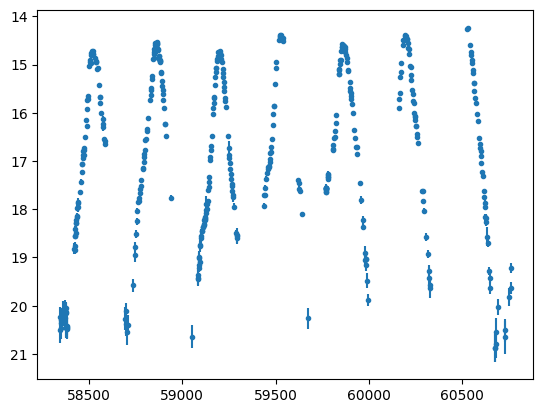

572789.7570732959
set()


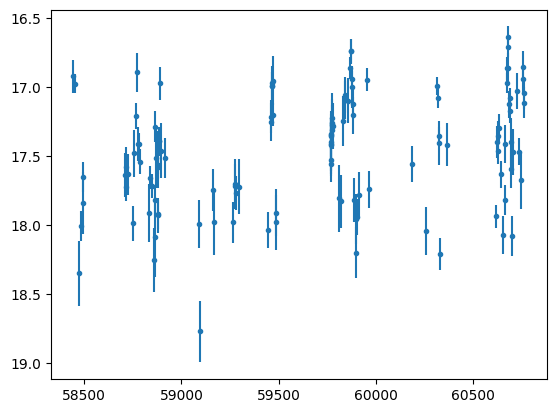

7.769471180321771
set()


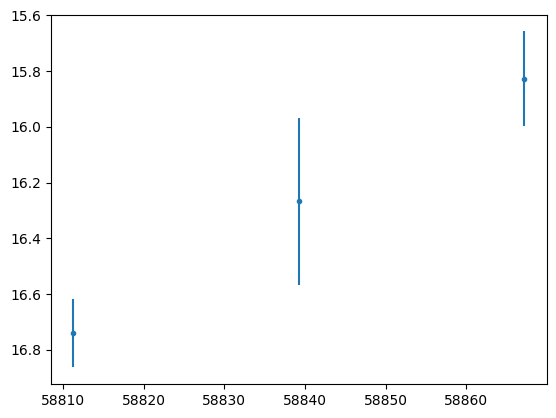

2.200816183570292
set()


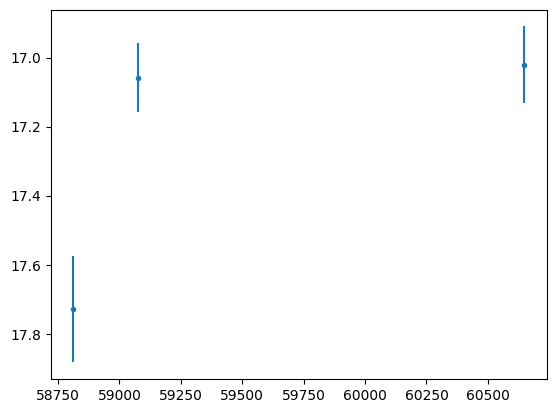

13610.726912639779
set()


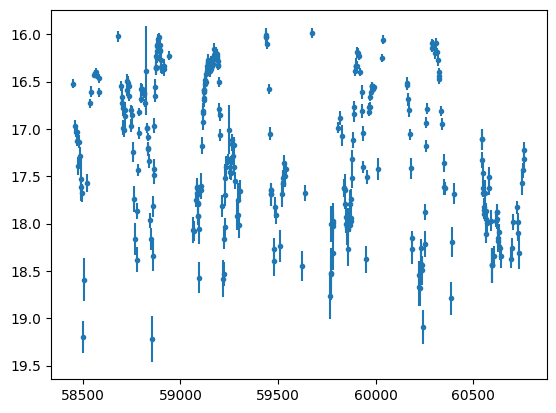

9889489.462878786
set()


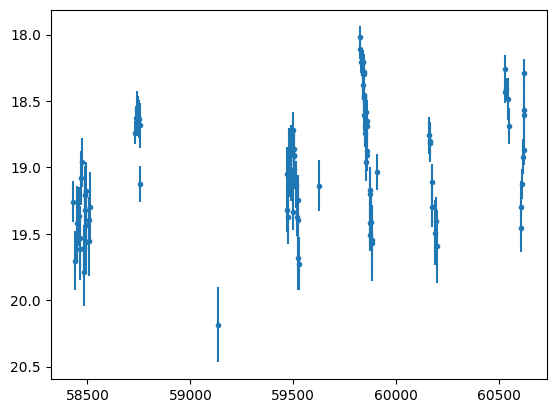

6557.156652883942
set()


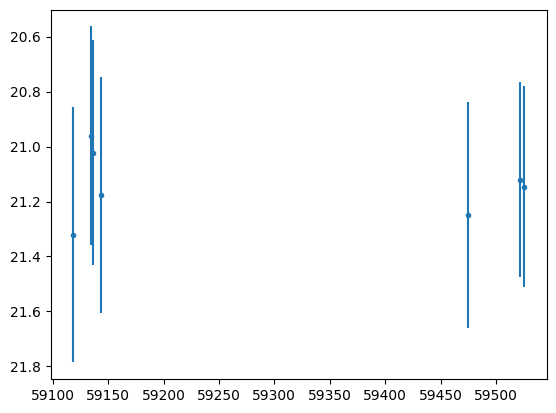

2.0000000000000004
set()


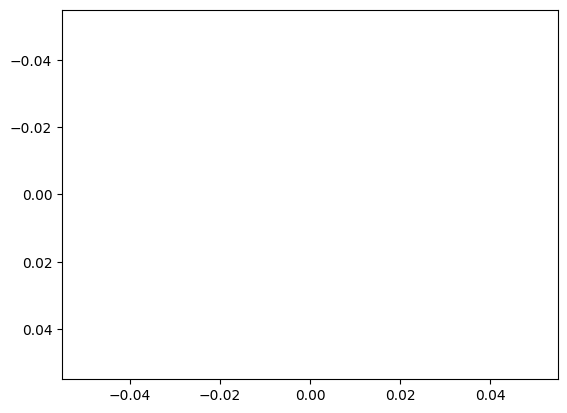

5448412.981353977
set()


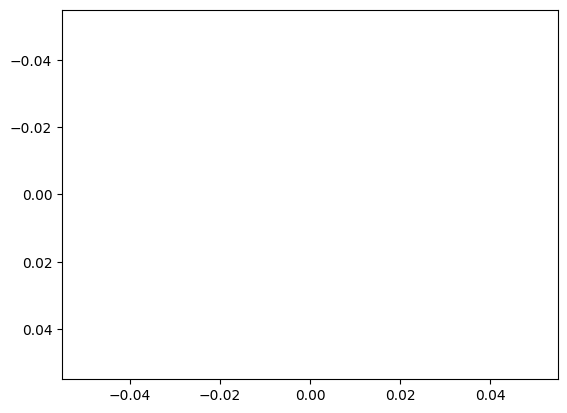

2.0
set()


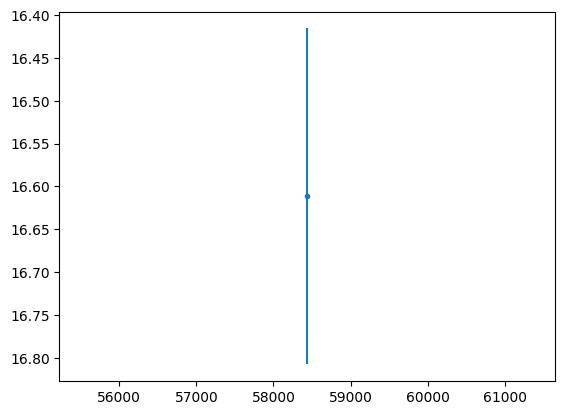

182014.6998300213
set()


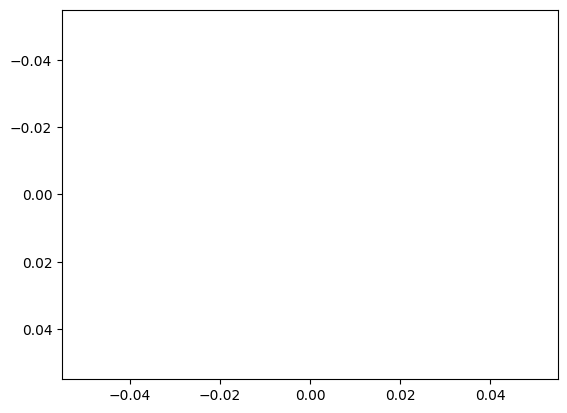

6.606579396779043
set()


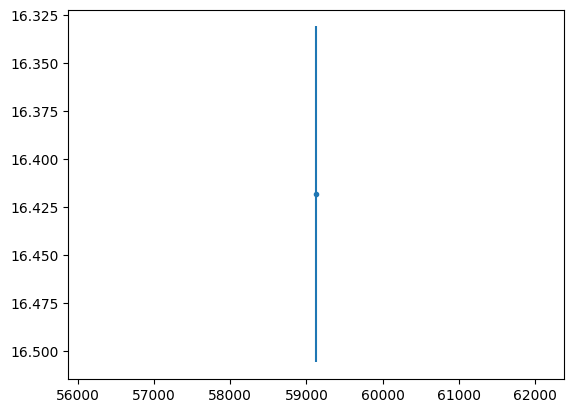

2.0
set()


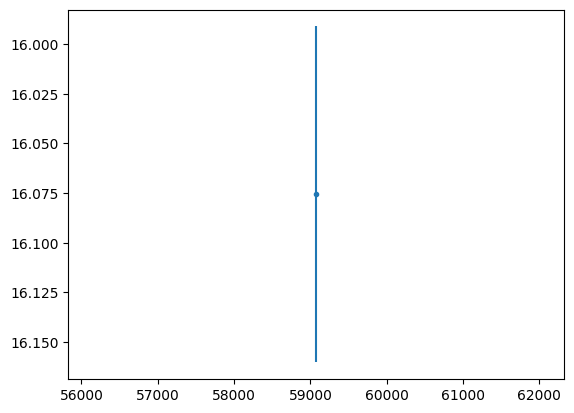

1.9999999999999998
set()


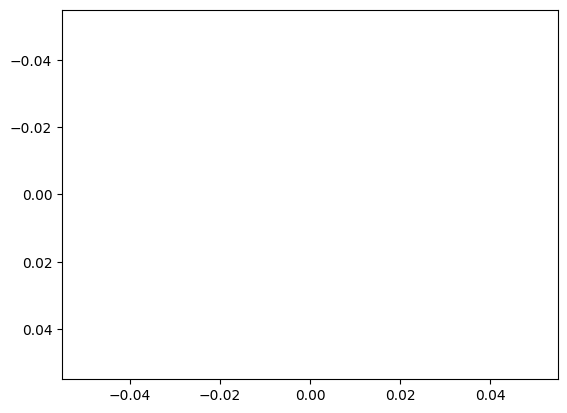

2.815465530772356
set()


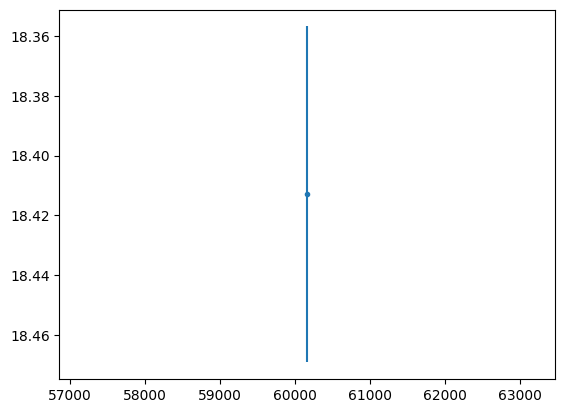

182014.6998300213
set()


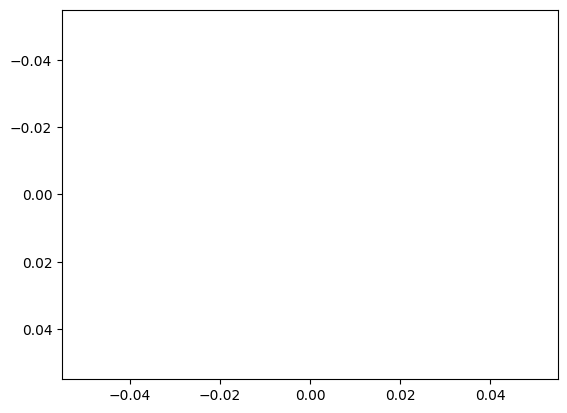

2.0
set()


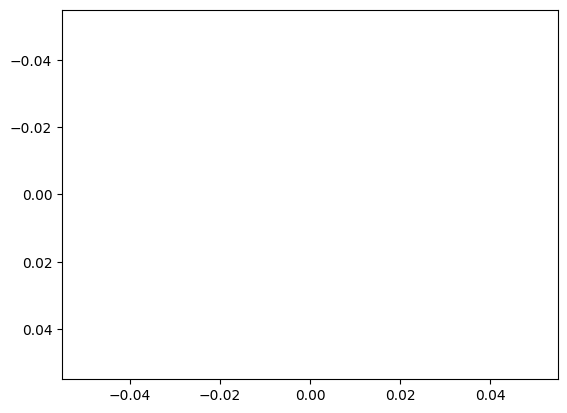

86801.0134265164
set()


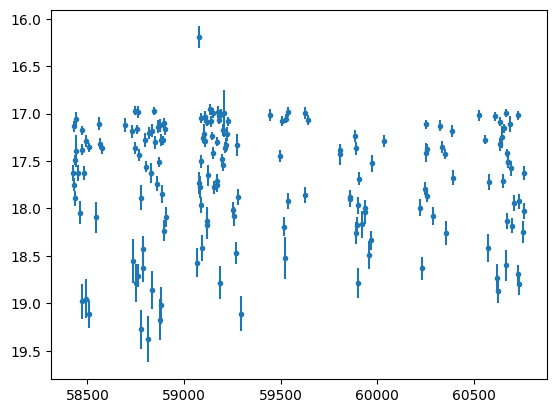

9786084.41422641
set()


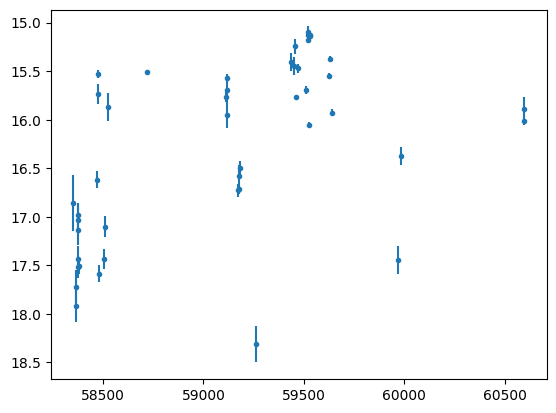

133.4677137986794
set()


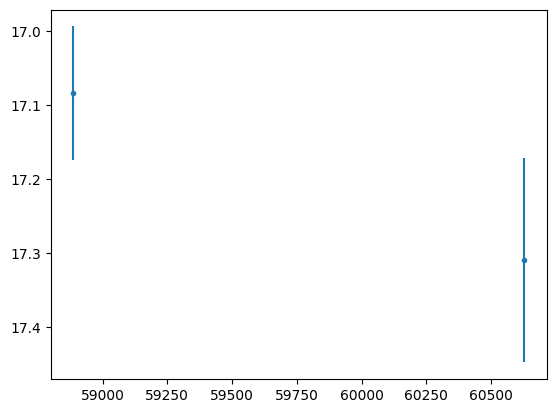

6.42029848341188
set()


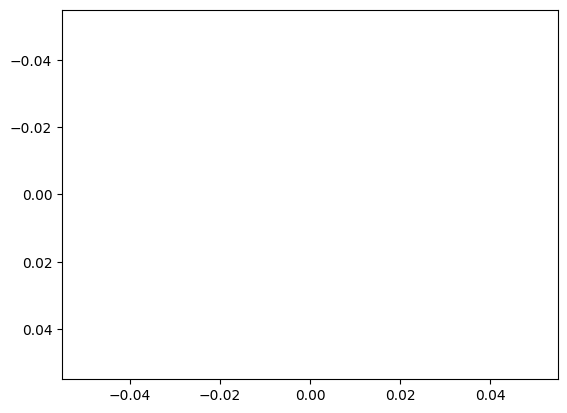

5448412.981353977
set()


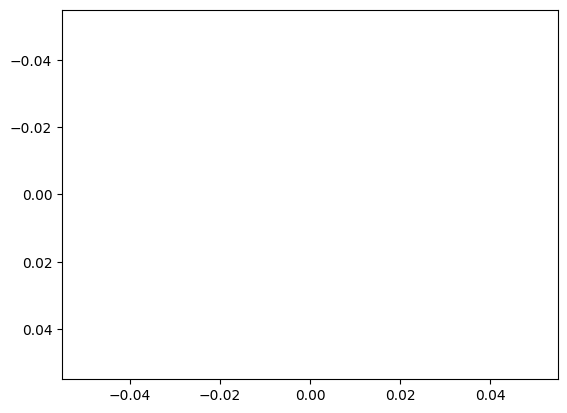

6557.156652883942
set()


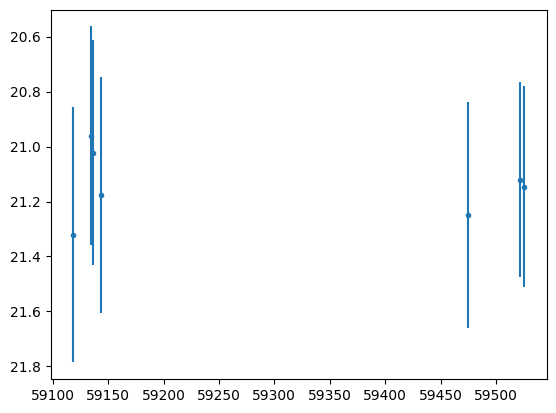

3984116.68712971
set()


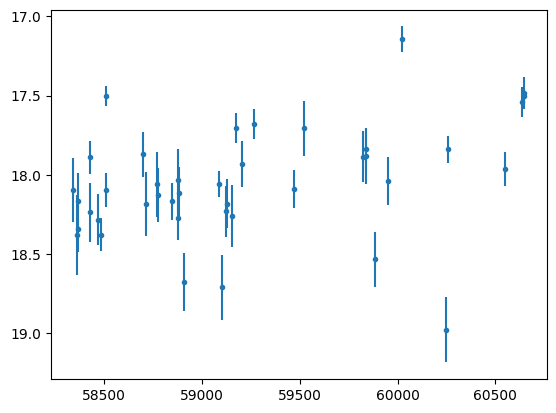

2.0
set()


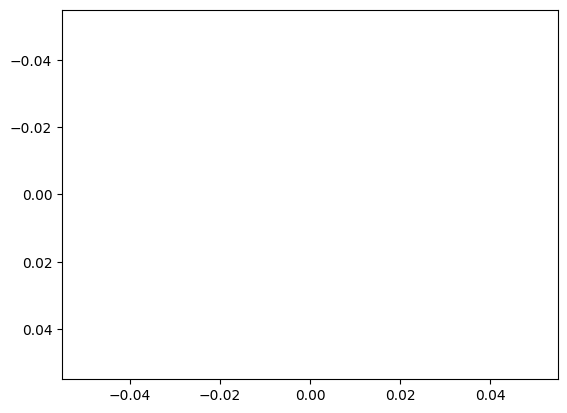

9.464018350208807
set()


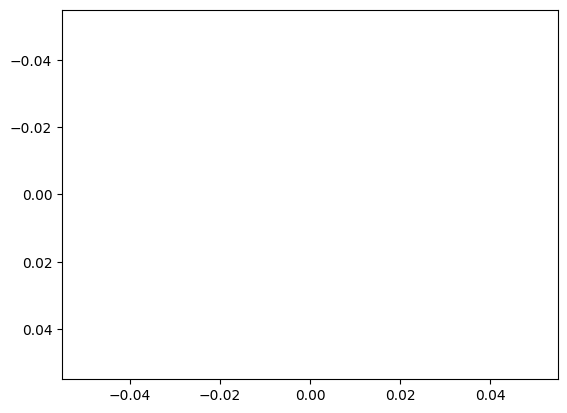

1.271357021607241
set()


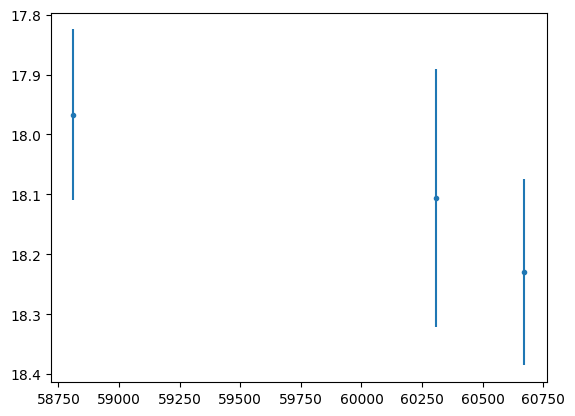

139.35386811294035
set()


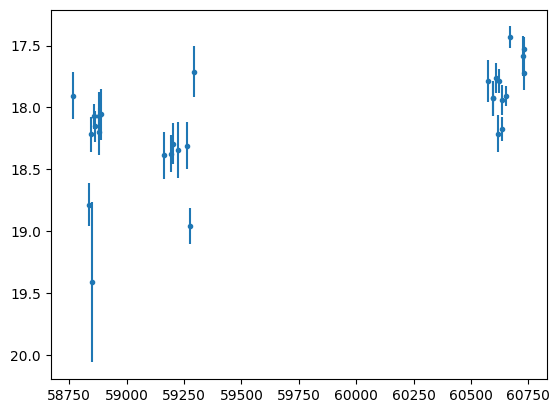

100090084.70680586
set()


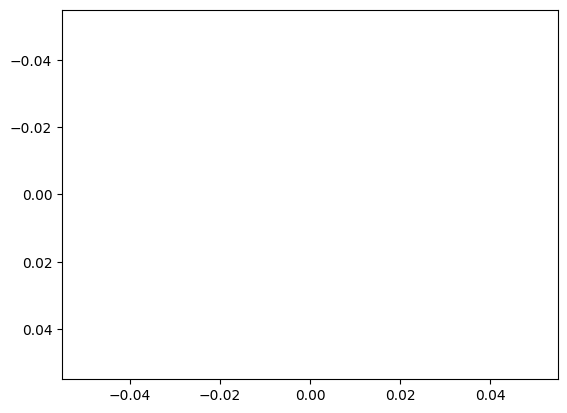

296586279.7972133
set()


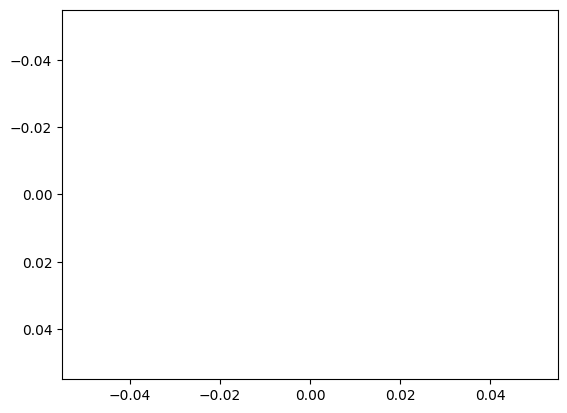

2481.16131700438
set()


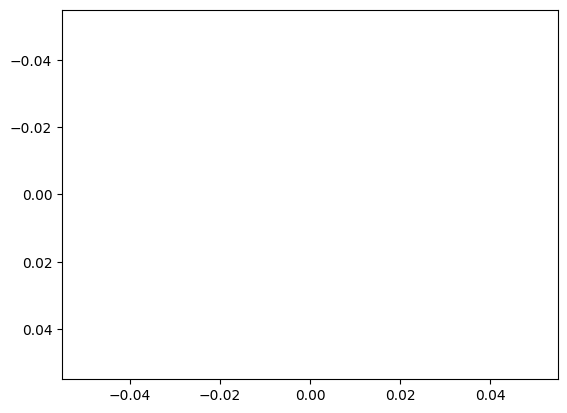

916727.8458818074
set()


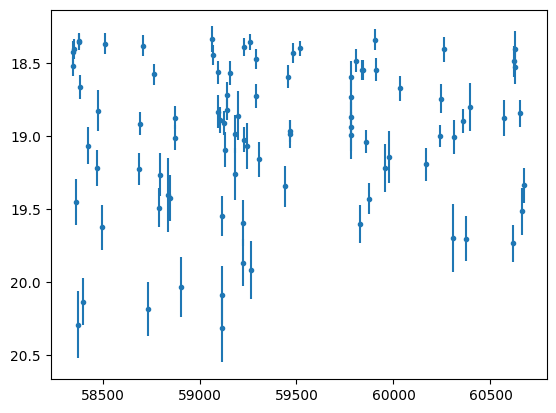

3.5301274451208604
set()


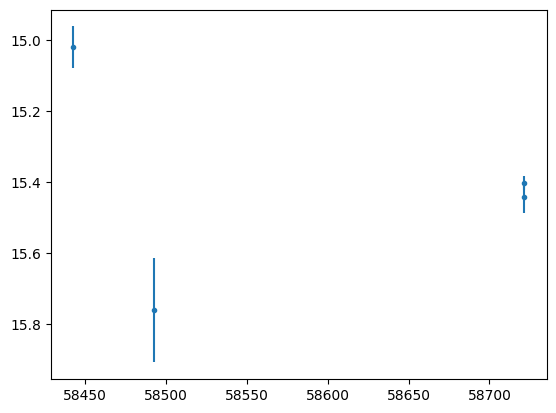

6459371.138302639
set()


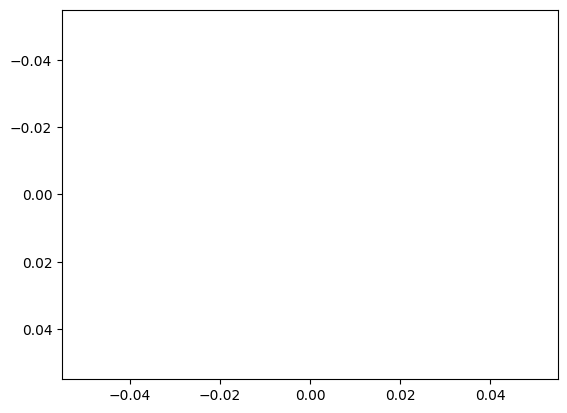

11722060.33471455
set()


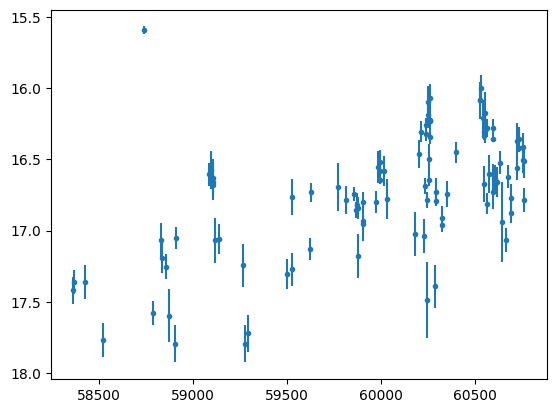

8095027.011330483
set()


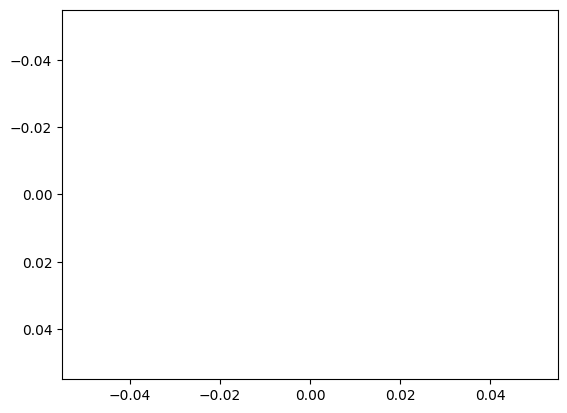

309773626.81953317
set()


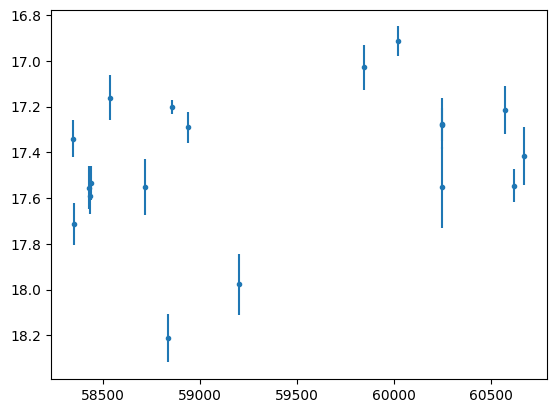

6425.849916793946
set()


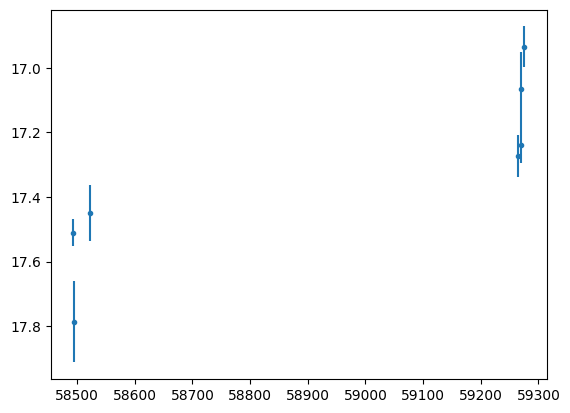

2.0
set()


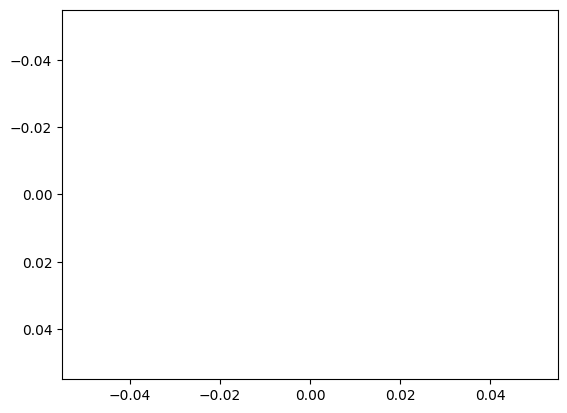

2.0
set()


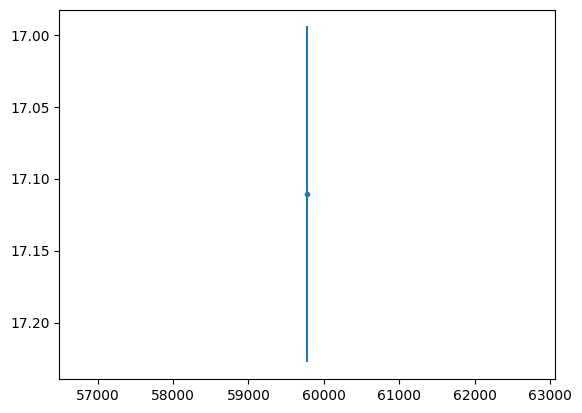

8095027.011330483
set()


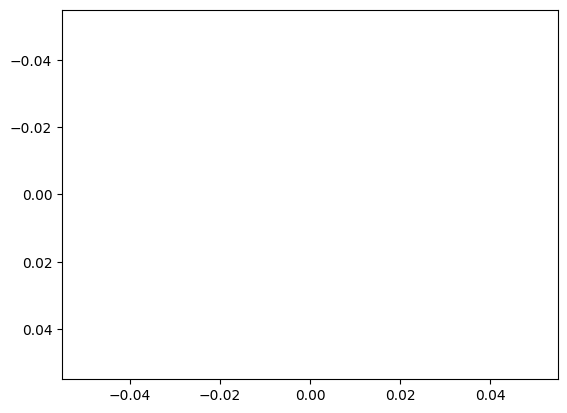

2.0
set()


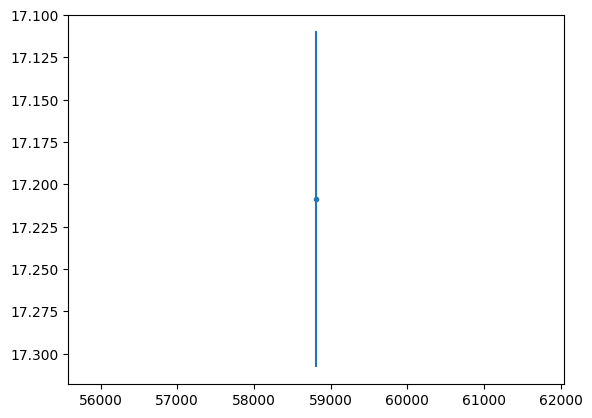

2.0000000000000004
set()


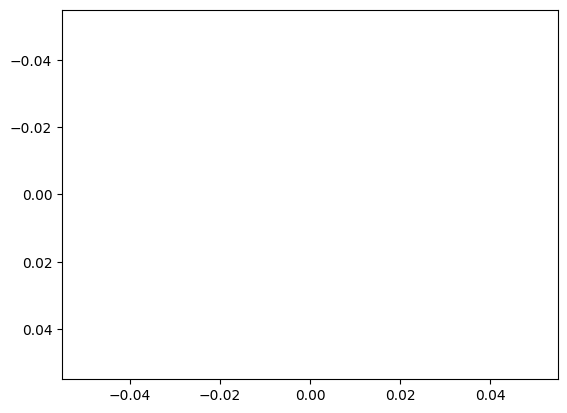

916727.8458818074
set()


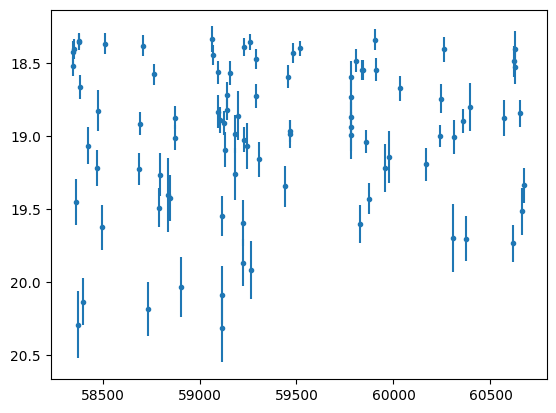

6459371.138302639
set()


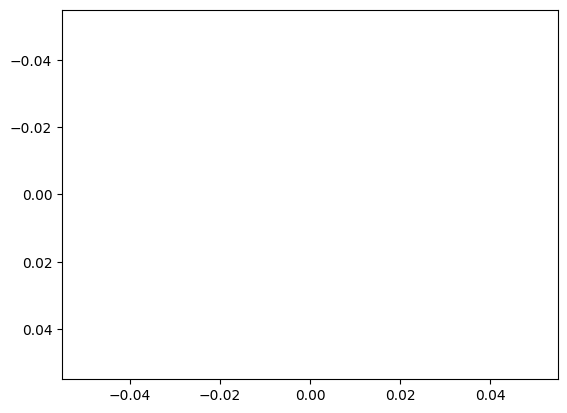

439565.62198164465
set()


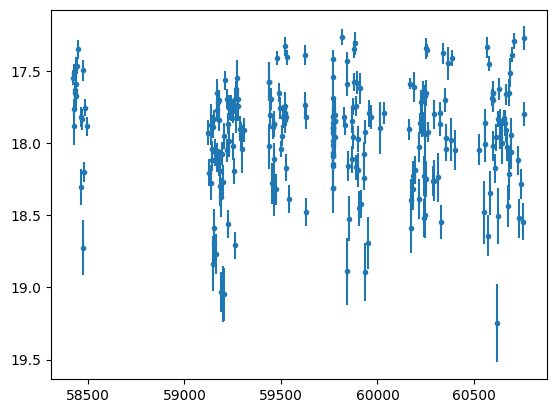

48.14244437009751
set()


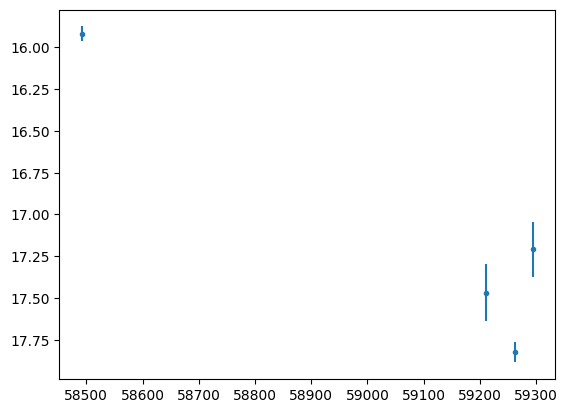

55331.40466838266
set()


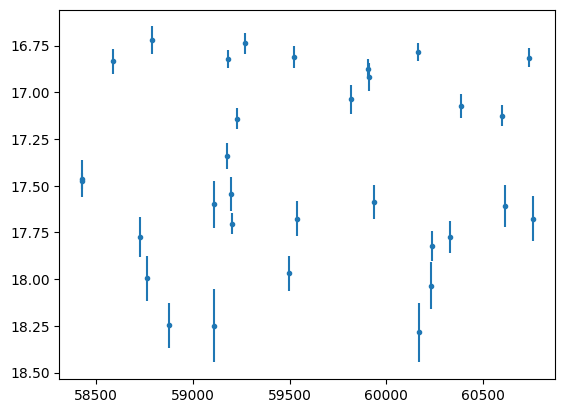

728.3036704277663
set()


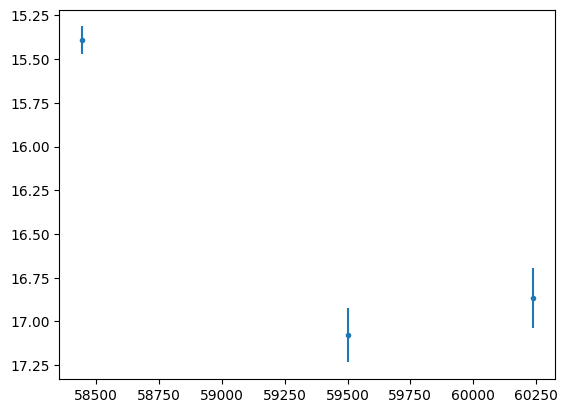

119178992.17080311
set()


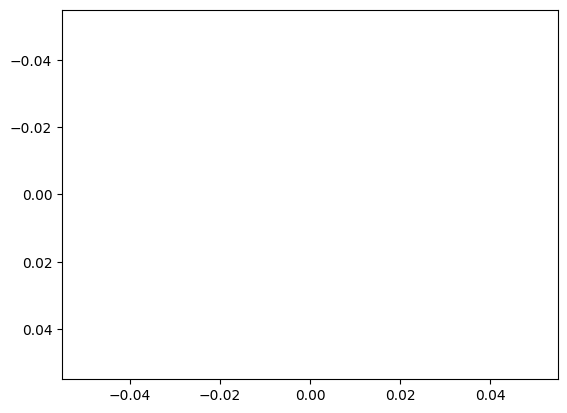

1.0241101935887027
set()


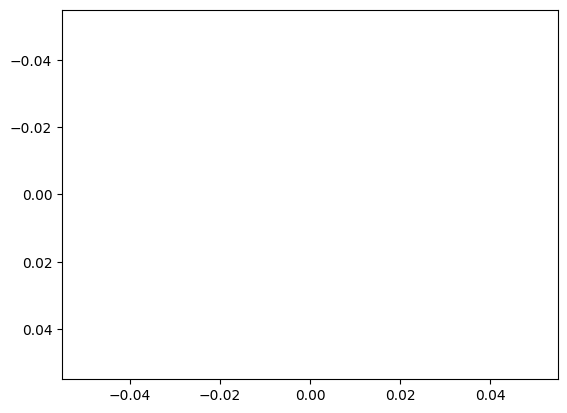

76074.44037490971
set()


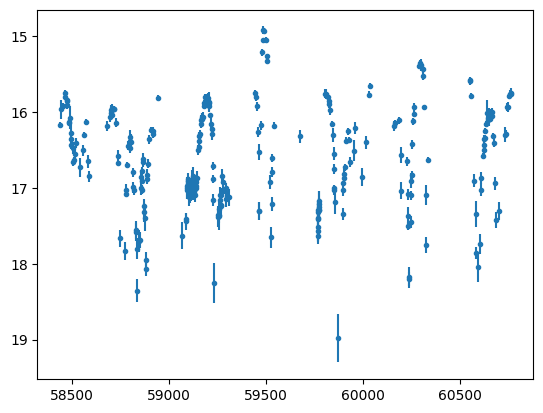

13322335.858353062
set()


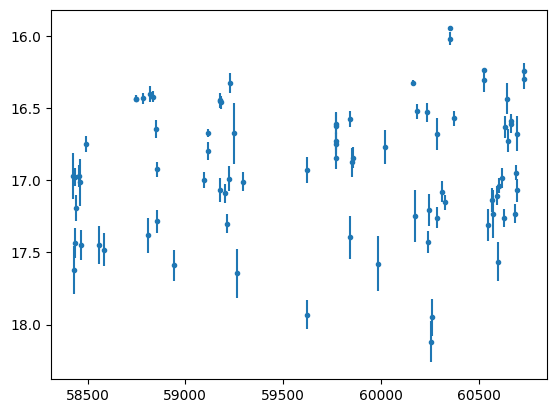

2.0
set()


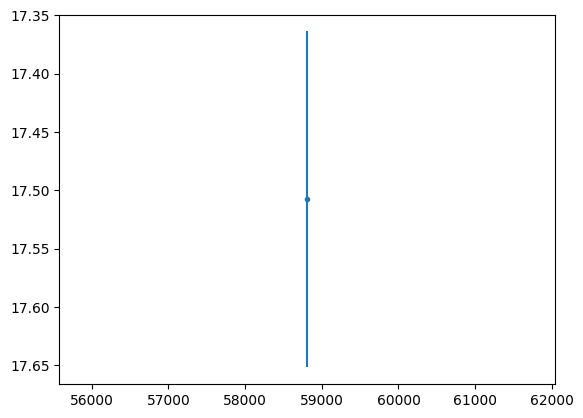

2.0
set()


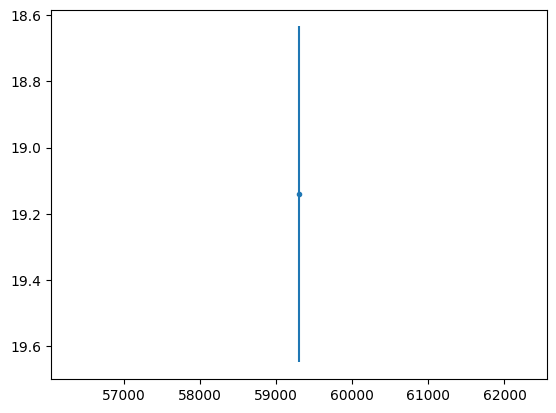

13322335.858353062
set()


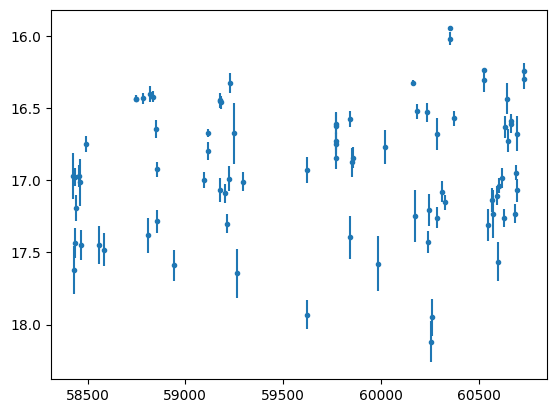

16850.31286479868
set()


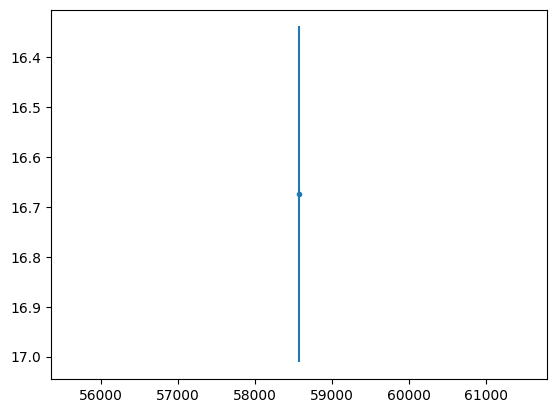

14.961725695410511
set()


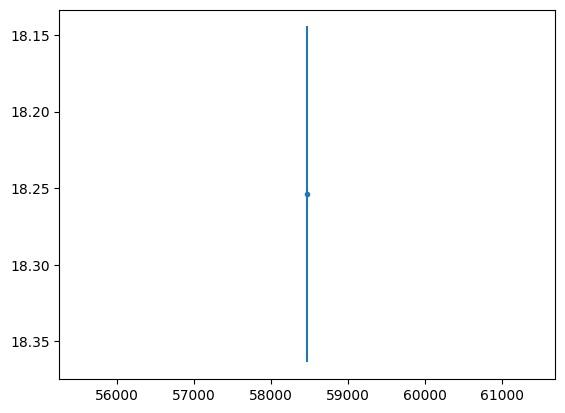

1.9999999999999996
set()


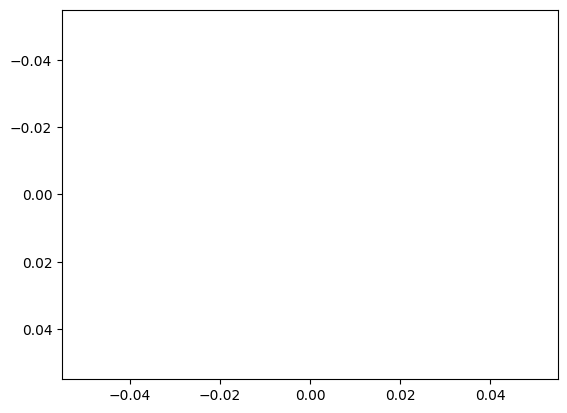

2.0
set()


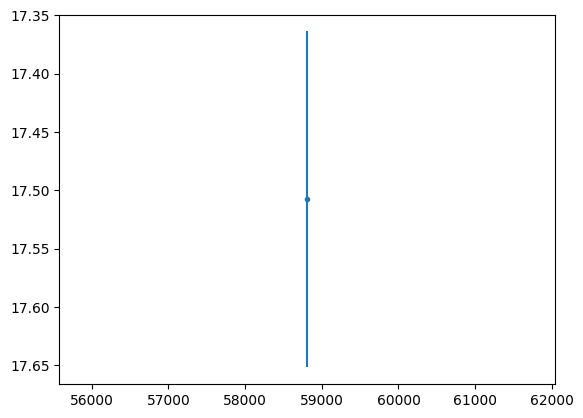

10.57231235827396
set()


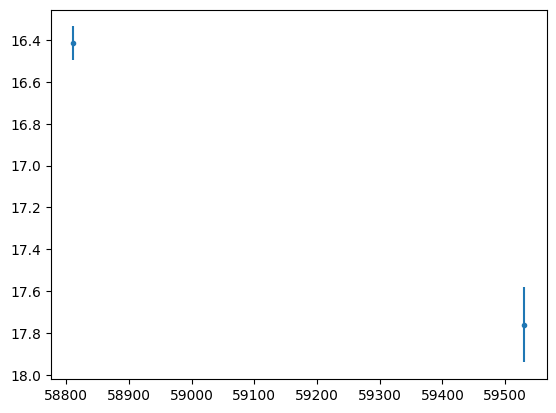

2.0
set()


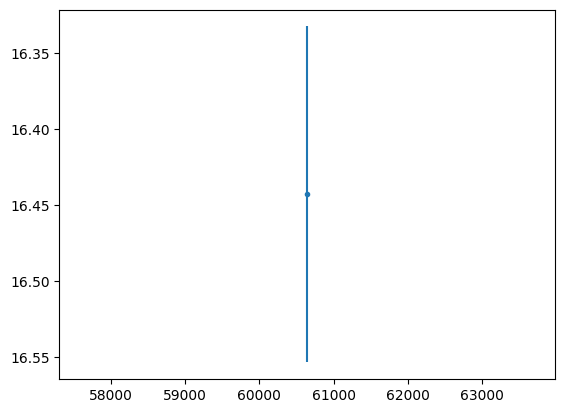

19644705.872303538
set()


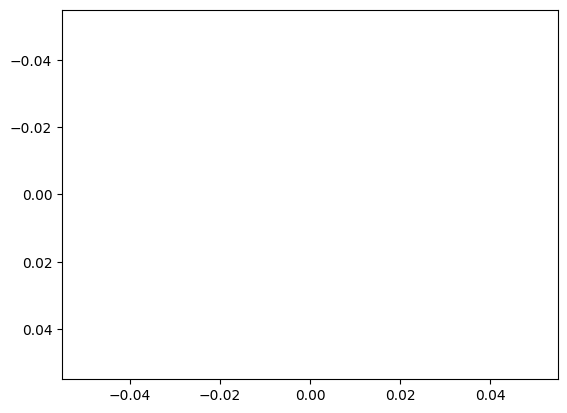

2.0
set()


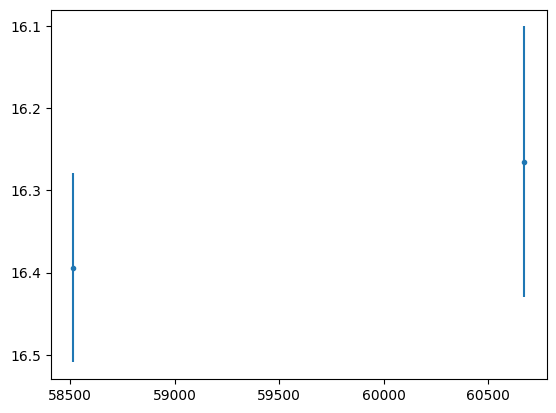

28.474198642458767
set()


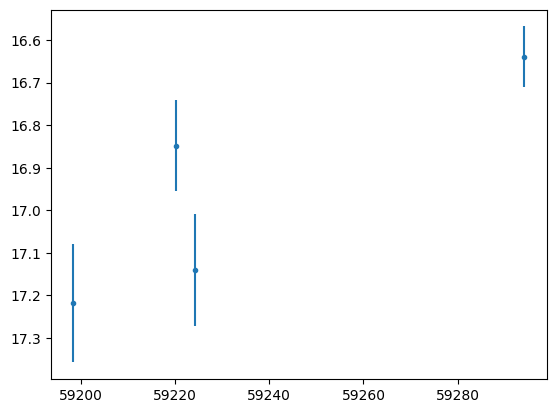

1.9999999999999996
set()


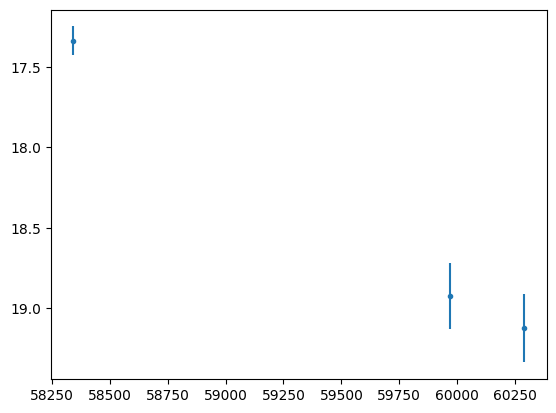

2.0
set()


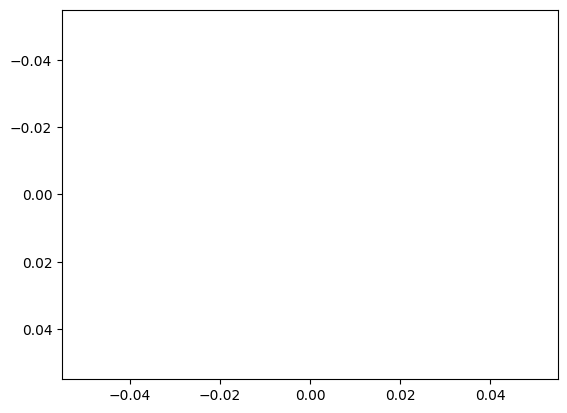

16510645.21614369
set()


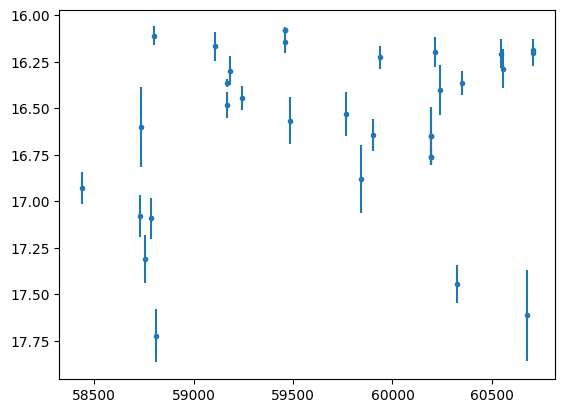

3100216.497037769
set()


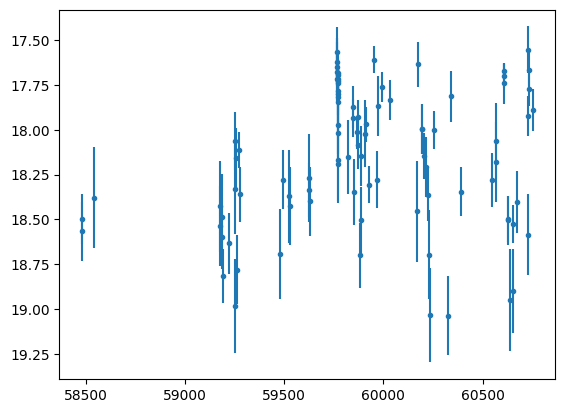

In [46]:
for result in report['results']:
    try:
        print(result['locus_data'].to_dict()['properties']['feature_eta_e_magn_r'])
    except:
        continue
    print(result['new_tags'])
    plot_lightcurve(result['locus_data'])

In [23]:
report['results'][-2]['locus_data'].timeseries.to_pandas()

,alert_id,ant_dec,ant_mag,ant_magerr,ant_maglim,ant_mjd,ant_passband,ant_ra,ant_survey,ant_time_received,...,ztf_tblid,ztf_tooflag,ztf_xpos,ztf_ypos,ztf_zpclrcov,ztf_zpmed,ant_mag_corrected,ant_magerr_corrected,ant_magulim_corrected,ant_magllim_corrected
time,,,,,,,,,,,,,,,,,,,,,
2025-06-05 11:03:39.997452,ztf_upper_limit:ZTF25aaxfccd-3077460873215,NaN,NaN,NaN,20.220900,60831.460880,g,NaN,2,1750766388,...,<NA>,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-06-09 10:04:26.996165,ztf_upper_limit:ZTF25aaxfccd-3081419753215,NaN,NaN,NaN,19.028601,60835.419757,g,NaN,2,1750766388,...,<NA>,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-06-12 10:00:31.996796,ztf_upper_limit:ZTF25aaxfccd-3084417033215,NaN,NaN,NaN,17.851601,60838.417037,R,NaN,2,1750766388,...,<NA>,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-06-12 10:33:57.003824,ztf_upper_limit:ZTF25aaxfccd-3084440243215,NaN,NaN,NaN,18.164301,60838.440243,g,NaN,2,1750766388,...,<NA>,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-06-14 10:00:53.000624,ztf_upper_limit:ZTF25aaxfccd-3086417283215,NaN,NaN,NaN,19.025499,60840.417280,g,NaN,2,1750766388,...,<NA>,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-06-18 09:36:41.999040,ztf_upper_limit:ZTF25aaxfccd-3090400483215,NaN,NaN,NaN,19.367800,60844.400486,R,NaN,2,1750766388,...,<NA>,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-06-18 10:09:09.999377,ztf_upper_limit:ZTF25aaxfccd-3090423033215,NaN,NaN,NaN,19.211800,60844.423032,g,NaN,2,1750766388,...,<NA>,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-06-20 10:09:43.997744,ztf_upper_limit:ZTF25aaxfccd-3092423423215,NaN,NaN,NaN,19.924101,60846.423426,R,NaN,2,1750766388,...,<NA>,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-06-20 10:10:25.003195,ztf_upper_limit:ZTF25aaxfccd-3092423904515,NaN,NaN,NaN,19.969601,60846.423900,R,NaN,2,1750766388,...,<NA>,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
